In [ ]:
import os

import requests

os.environ["CUDA_VISIBLE_DEVICES"] = "6"
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

pdfs = {
    "MALM": "https://www.ikea.com/us/en/assembly_instructions/malm-4-drawer-chest-white__AA-2398381-2-100.pdf",
    "BILLY": "https://www.ikea.com/us/en/assembly_instructions/billy-bookcase-white__AA-1844854-6-2.pdf",
    "BOAXEL": "https://www.ikea.com/us/en/assembly_instructions/boaxel-wall-upright-white__AA-2341341-2-100.pdf",
    "ADILS": "https://www.ikea.com/us/en/assembly_instructions/adils-leg-white__AA-844478-6-2.pdf",
    "MICKE": "https://www.ikea.com/us/en/assembly_instructions/micke-desk-white__AA-476626-10-100.pdf",
}

output_dir = "data"
os.makedirs(output_dir, exist_ok=True)

for name, url in pdfs.items():
    response = requests.get(url)
    pdf_path = os.path.join(output_dir, f"{name}.pdf")

    with open(pdf_path, "wb") as f:
        f.write(response.content)

    print(f"Downloaded {name} to {pdf_path}")

print("Downloaded files:", os.listdir(output_dir))

Downloaded MALM to data/MALM.pdf
Downloaded BILLY to data/BILLY.pdf
Downloaded BOAXEL to data/BOAXEL.pdf
Downloaded ADILS to data/ADILS.pdf
Downloaded MICKE to data/MICKE.pdf
Downloaded files: ['BOAXEL.pdf', 'MALM.pdf', 'MICKE.pdf', 'BILLY.pdf', 'ADILS.pdf']


In [ ]:
import os

from pdf2image import convert_from_path


def convert_pdfs_to_images(pdf_folder):
    pdf_files = [f for f in os.listdir(pdf_folder) if f.endswith(".pdf")]
    all_images = {}

    for doc_id, pdf_file in enumerate(pdf_files):
        pdf_path = os.path.join(pdf_folder, pdf_file)
        images = convert_from_path(pdf_path)
        all_images[doc_id] = images

    return all_images


all_images = convert_pdfs_to_images("data")

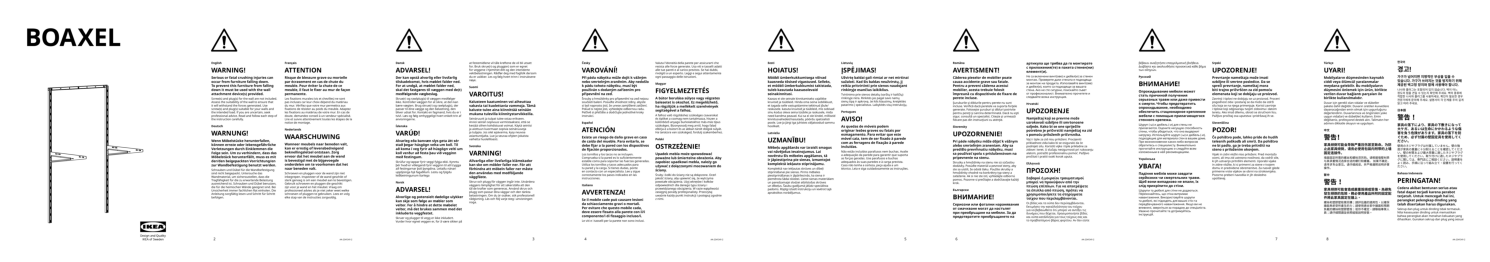

In [25]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 8, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    img = all_images[0][i]
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
from byaldi import RAGMultiModalModel

docs_retrieval_model = RAGMultiModalModel.from_pretrained(
    "vidore/colpali-v1.2", verbose=0
)

docs_retrieval_model.index(
    input_path="data/",
    index_name="image_index",
    store_collection_with_index=False,
    overwrite=True,
)

text_query = "How many people are needed to assemble the Malm?"

results = docs_retrieval_model.search(text_query, k=3)
results

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

overwrite is on. Deleting existing index image_index to build a new one.
Indexing file: data/BOAXEL.pdf
Indexing file: data/MALM.pdf
Indexing file: data/MICKE.pdf
Indexing file: data/BILLY.pdf
Indexing file: data/ADILS.pdf


[{'doc_id': 1, 'page_num': 1, 'score': 14.125, 'metadata': {}, 'base64': None},
 {'doc_id': 1, 'page_num': 3, 'score': 11.75, 'metadata': {}, 'base64': None},
 {'doc_id': 3, 'page_num': 13, 'score': 11.25, 'metadata': {}, 'base64': None}]

In [ ]:
def get_grouped_images(results, all_images):
    grouped_images = []

    for result in results:
        doc_id = result["doc_id"]
        page_num = result["page_num"]
        grouped_images.append(
            all_images[doc_id][page_num - 1]
        )  # page_num are 1-indexed, while doc_ids are 0-indexed. Source https://github.com/AnswerDotAI/byaldi?tab=readme-ov-file#searching

    return grouped_images


grouped_images = get_grouped_images(results, all_images)

In [ ]:
import torch
from qwen_vl_utils import process_vision_info
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor

min_pixels = 224 * 224
max_pixels = 1024 * 1024

vl_model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    torch_dtype=torch.bfloat16,
)
vl_model.cuda().eval()

vl_model_processor = Qwen2VLProcessor.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct", min_pixels=min_pixels, max_pixels=max_pixels
)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
def answer_with_multimodal_rag(
    vl_model,
    docs_retrieval_model,
    vl_model_processor,
    grouped_images,
    text_query,
    top_k,
    max_new_tokens,
):
    results = docs_retrieval_model.search(text_query, k=top_k)
    grouped_images = get_grouped_images(results, all_images)

    chat_template = [
        {
            "role": "user",
            "content": [{"type": "image", "image": image} for image in grouped_images]
            + [{"type": "text", "text": text_query}],
        }
    ]

    # Prepare the inputs
    text = vl_model_processor.apply_chat_template(
        chat_template, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(chat_template)
    inputs = vl_model_processor(
        text=[text],
        images=image_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to("cuda")

    # Generate text from the vl_model
    generated_ids = vl_model.generate(**inputs, max_new_tokens=max_new_tokens)
    generated_ids_trimmed = [
        out_ids[len(in_ids) :]
        for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]

    # Decode the generated text
    output_text = vl_model_processor.batch_decode(
        generated_ids_trimmed,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False,
    )

    return output_text

In [36]:
output_text = answer_with_multimodal_rag(
    vl_model=vl_model,
    docs_retrieval_model=docs_retrieval_model,
    vl_model_processor=vl_model_processor,
    grouped_images=grouped_images,
    text_query="Как мне собрать стол Micke?",
    top_k=3,
    max_new_tokens=500,
)
print(output_text[0])

Для сборки стола Micke вам понадобятся следующие инструменты и материалы:

1. **Инструменты:**
   - Ножницы
   - Набор ключей для гаек и болтов
   - Набор ключей для шестигранных головок
   - Набор ключей для шестигранных головок с отверткой

2. **Материалы:**
   - Стол Micke
   - Набор винтов и гаек
   - Набор шестигранных головок

**Шаги по сборке:**

1. **Откройте упаковку и извлеките все компоненты стола.**

2. **Сборка основания стола:**
   - Сначала соберите основание стола, используя винты и гайки.
   - Убедитесь, что все детали правильно установлены и затянуты.

3. **Сборка верхней части стола:**
   - Установите верхнюю часть стола на основание.
   - Затяните винты и гайки, чтобы соединить верхнюю и нижнюю части стола.

4. **Установка ножек:**
   - Установите ножки стола на нижнюю часть стола.
   - Затяните винты и гайки, чтобы закрепить ножки.

5. **Установка столешницы:**
   - Установите столешницу на стол.
   - Убедитесь, что столешница правильно установлена и удерживается в